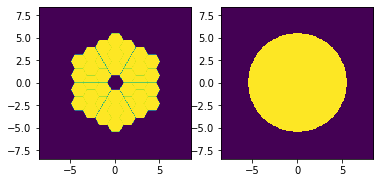

0.20213951012215442


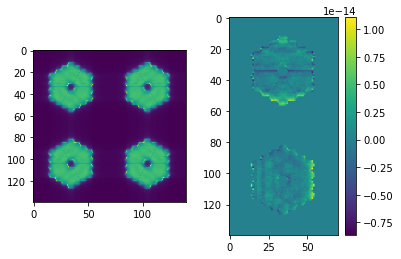

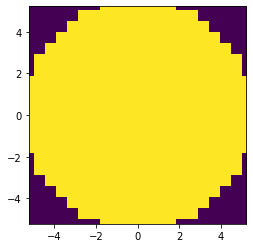

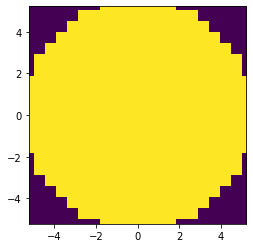

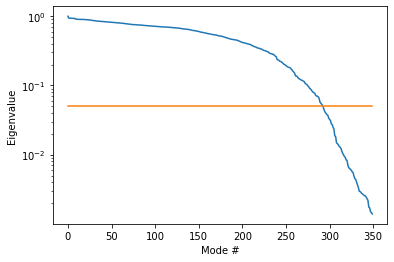

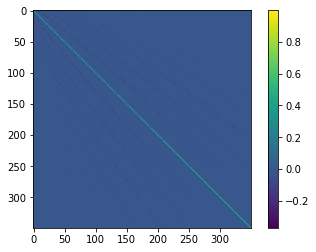

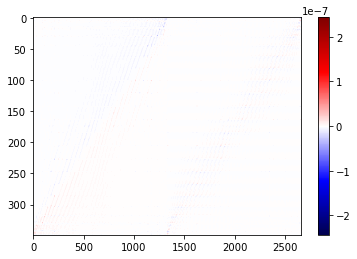

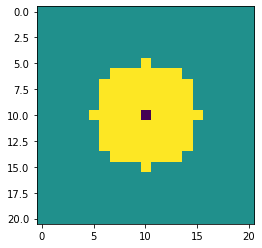

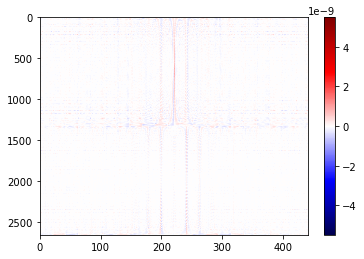

(2660, 441)


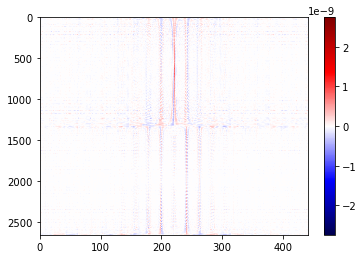

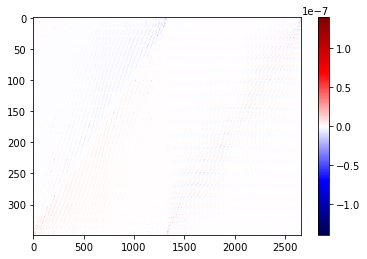

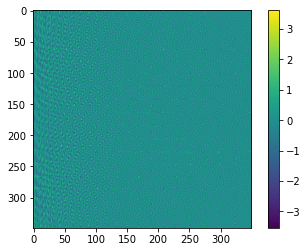

In [1]:
# Setup Keck system
#using HCIPY '0.4.0'
%run KeckPyWFS-SETUP.ipynb 

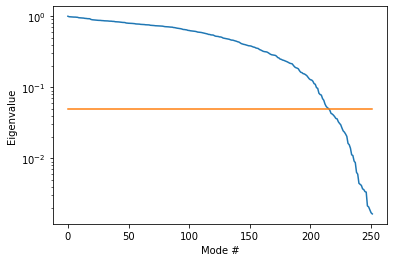

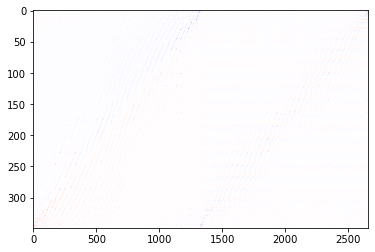

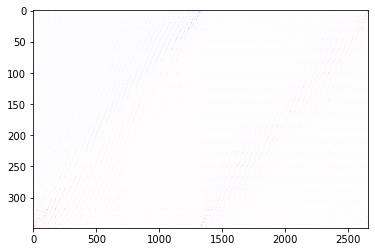

In [2]:
# Reduce number of control modes (without re-calibrating)
nModes_new = 252
# Crop number of controlled modes
CM_new = recomputeCM(IM,nModes_new,rcond,mode_dm_proj)
cLim = np.max(np.abs(CM))
plt.imshow(CM,aspect='auto',cmap='seismic',vmin=-cLim,vmax=cLim)
plt.show()
plt.imshow(CM_new,aspect='auto',cmap='seismic',vmin=-cLim,vmax=cLim)
plt.show()
# Re-apply fourier filte

In [3]:
def recomputeCM(IM,nModes,rcond,mode_dm_proj):
    nModes_old = np.shape(IM)[1]
    if nModes_old<nModes:
        print('WARNING: higher # modes requested than calibrated!')
        print('Using %g modes only'%(nModes_old))
        IM_new = IM
    else:
        IM_new = IM[:,0:nModes]
        
    svd = SVD(IM_new)
    CM_modal = computeCM(IM_new,rcond,svd)
    CM = np.matmul(mode_dm_proj[:,0:nModes],CM_modal)
    return CM

In [4]:
##### AO loop parameters #####
gain = 0.4
leak = 0.01
#nIter = 31000
nIter = 200
dm.flatten()
count = 0
layer.t = 0
delay=1

#primary mirror configuration
ksm.flatten()
#ksm.random(120E-9) --> random 120nm rms on the primary mirror (used by Becky to match our on-sky stuff.
#this could be more (see Sam Raglands papers on a better value?)

In [6]:
#include aberration to degrate psf on pyramid tip to account for NCPA to nirc2
include_aberration=True
aberration_ptv = 6.28e-6 # m
tip_tilt_defocus = make_zernike_basis(4, D_full, pupil_grid, starting_mode=2)
aberration = SurfaceAberration(pupil_grid, aberration_ptv, D_full, remove_modes=tip_tilt_defocus, exponent=-3)
wf_res =wf_ngs.copy()
# Propograte to the WFS
#Apply NCPA seen by the pyramid to correct for NIRC2
if include_aberration:
    wf_res = aberration(wf_res)
wfs_wf = mpwfs.forward(wf_res)
pwfs_im_ref, pwfs_slopes_ref = propagatePyWFS(wfs_camera,mpwfs,wfs_wf,modSteps,bin_wfs,pwfs_grid,pwfs_mask,pwfs_refSlopes,dt)



/opt/anaconda3/envs/mypython3/lib/python3.7/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


In [7]:
#setup coronagraph --> will move this to SETUP eventually so we have L-band coronagraph capability
coronagraph=True
image_dt=0.01 #seconds
image_frames=image_dt*frameRate
image=int(np.floor(nIter/image_frames))
if coronagraph:
    f0_k=43.6*0.41*10**8.*(73.4)
    wavelength_L = 3.776e-6
    wf_pup_L = Wavefront(pupil,wavelength=wavelength_L) #2.2e-6
    wf_pup_L.total_power = dt*f0_k*10.**(-mag/2.5) #assume the mag are the same and we dont have a camera so add the dt
    #########setup the focal plane propagator##########
    angular_scale_L=wavelength_L/D
    #change this here to get NIRC2 scaling/more pixels
    focal_grid_L = make_focal_grid(q=24, num_airy=20,spatial_resolution=angular_scale_L)
    propagator_L = FraunhoferPropagator(pupil_grid, focal_grid_L)

    ############ Make coronagraph ################
    lyot=make_keck_Lband_lyot(return_segments=False,normalized=False)
    lyot_mask = evaluate_supersampled(lyot, pupil_grid, 4)
    lyot_stop = Apodizer(lyot_mask)
    #okay lets make the vortex with charge 2 & plot
    coron=VortexCoronagraph(pupil_grid, charge=2)

    #okay lets propagrate our WF through the coronagraph
    wf_in_L=wf_pup_L.copy()
    lyot_plane = coron(wf_in_L)
    # imshow_field(lyot_plane.intensity, cmap='inferno')
    # plt.savefig('./test_fp1.png')
    post_lyot_mask = lyot_stop(lyot_plane)
    img = propagator_L(post_lyot_mask).intensity
    # imshow_field(np.log10(img / norm_k), cmap='inferno')
    # plt.colorbar()
    # plt.savefig('./test_fp2.png')
    
    psf_cube = np.zeros((image, 960,960))
    coro_cube = np.zeros((image, 960,960))
    coro_img = np.zeros(960*960)
    psf_img  = np.zeros(960*960)
    
    
    
    

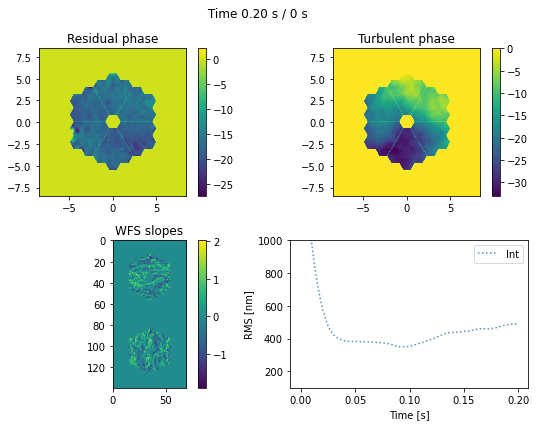

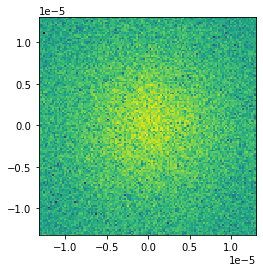

In [8]:
##### Closed loop #####
# Lists to append data generated in AO loop
sr=[]
open_loop_phase=[]
residual_phase=[]
integrator_rms=[]
# Animation
fig=plt.figure(figsize=(8,6))
#anim = GifWriter('closedloop.mp4', framerate=3)
count=0
count_image=0
for n in range(nIter):
    # Advance the turbulence
    layer.t = count*dt 
    # Get a clean wavefront that is our NGS
    wf_in = ksm.forward(wf_ngs.copy())
    # Extract the phase for WFS wavelength
    true_phase=layer.phase_for(lambda_wfs) 
    # Propagate through the atmosphere and dm
    wf_turb = layer.forward(wf_in)
    wf_res = dm.forward(wf_turb)
    # Propograte to the WFS
    #Apply NCPA seen by the pyramid to correct for NIRC2
    if include_aberration:
        wf_res = aberration(wf_res)
    wfs_wf = mpwfs.forward(wf_res)
    pwfs_im, pwfs_slopes = propagatePyWFS(wfs_camera,mpwfs,wfs_wf,modSteps,bin_wfs,pwfs_grid,pwfs_mask,pwfs_refSlopes,dt)
    
    # Reconstruction  
    recon = dm.actuators.copy()*0
    recon[dm_pupil>0]=np.matmul(CM_filt,pwfs_slopes-pwfs_slopes_ref)

    #advance the atmosphere delay steps
    count+=delay
    layer.t = (count)*dt   
    
    #control
    dm.actuators = (1-leak)*dm.actuators - gain*recon
    # RMS
    res=layer.phase_for(lambda_wfs)+dm.phase_for(lambda_wfs)
    resPhase = pupil*(res - np.mean(res[pupil>0]))
    integrator_rms.append(1e9/k*np.sqrt(np.mean(resPhase[pupil>0]**2)))
    
    if coronagraph:
            # Propagate from SM to image plane
            #might want to change image size to better sample everything. 
            wf_wfs_after_atmos_L = layer.forward(ksm.forward(wf_in_L))
            wf_wfs_after_dm_L = dm.forward(wf_wfs_after_atmos_L)

            lyot_plane = coron(wf_wfs_after_dm_L) # vortex
            wf_coron = propagator_L.forward(lyot_stop(lyot_plane)) # Lyot stop, back to focal plane
            sci_img = wf_coron.intensity
           # print(sci_img.shape)
            coro_img += sci_img

            wf_focal = propagator_L.forward(wf_wfs_after_dm_L)
            psf_img += wf_focal.intensity

            if n % image_frames == 0: 
                
                coro_cube[count_image,:,:] = np.reshape(coro_img, (960,960))
                psf_cube[count_image,:,:] = np.reshape(psf_img, (960,960))

                del coro_img
                del psf_img
                coro_img = np.zeros(960*960)
                psf_img  = np.zeros(960*960)

                count_image+=1
    
    if n % (nIter-1) == 0: #==0 to plot and -10 to not plot
        plt.close(fig)
        fig=plt.figure(figsize=(8,6))
        plt.suptitle(' Time %.2f s / %d s' % (n*dt, dt*nIter))

        plt.subplot(2,2,1)
        plt.title('Residual phase')
        imshow_field(res*pupil)
        plt.colorbar()
        
        plt.subplot(2,2,2)   
        plt.title('Turbulent phase')
        imshow_field(layer.phase_for(lambda_wfs)*pupil)
        plt.colorbar()

        plt.subplot(2,2,3)
        plt.title('WFS slopes')
        [sx,sy] = slopeMaps(pwfs_slopes,pupil_mask)
        plt.imshow(np.concatenate([sx,sy]))
        plt.colorbar()
        
        plt.subplot(2,2,4)
        t = np.linspace(0,n*dt,n+1)
        plt.plot(t,integrator_rms,':',alpha=0.8,label='Int')
        plt.ylabel('RMS [nm]')
        plt.xlabel('Time [s]')
        plt.ylim([100,1000])
        plt.legend(loc=1)
        count+=1
        plt.tight_layout()
        plt.savefig('testing_new_keck_code')
        #plt.show()
        #plt.pause(0.1)
        #anim.add_frame()
#plt.close()
#anim.close()
#anim
plt.savefig('test_prediction.png',dpi=600)
plt.figure()
plt.imshow(np.log10(psf_cube[-1,:,:]))

OSError: File './psf_cube_keck_Lband_realistic_120RMS_NCPA.fits' already exists.

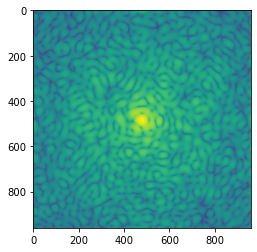

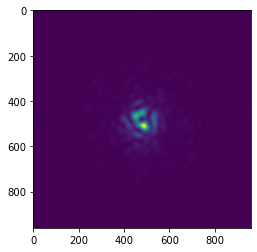

In [13]:
plt.imshow(coro_cube.sum(axis=0))
hdu = fits.PrimaryHDU(psf_cube)
hdul = fits.HDUList([hdu])
hdul.writeto('./psf_cube_keck_Lband_realistic_120RMS_NCPA.fits')

hdu = fits.PrimaryHDU(coro_cube)
hdul = fits.HDUList([hdu])
hdul.writeto('./coro_cube_keck_Lband_realistic_120RMS_NCPA.fits')
